# Bitcoin Price Prediction Project with ARIMA, XGBoost and LSTM
## LSTM

This notebook is part of Bitcoin Price Prediction Project with LSTM model.
Complete project consists of three notebooks with sections as below.

1. Abstract
2. Data description   # (01_BTC_Price_Prediction - ARIMA.ipynb notebook)
3. Gathering data     # (01_BTC_Price_Prediction - ARIMA.ipynb notebook)
4. Data preprocessing
5. ARIMA Model        # (01_BTC_Price_Prediction - ARIMA.ipynb notebook)
    - 5.1. ARIMA  =>  Introduction
    - 5.2. ARIMA Model  =>  function definition
    - 5.3. ARIMA Model  =>  Forecasting
        - complete data
        - data start from 2018-01-01
        - data start from 2021-01-01
    - 5.4. ARIMA Model  =>  summary
6. XGBoost            # (02_BTC_Price_Prediction - XGBoost.ipynb notebook)
    - 6.1. XGBRegressor  =>  Introduction
    - 6.2. XGBRegressor  =>  function definition
    - 6.3. XGBRegressor  =>  Forecasting
        - complete data
        - data start from 2018-01-01
        - data start from 2021-01-01
    - 6.4. XGBRegressor  =>  summary
7. LSTM Model         # (this notebook)
    - 7.1. LSTM  =>  Introduction
    - 7.2. LSTM  =>  function definition
    - 7.3. LSTM  =>  Forecasting
        - complete data
        - data start from 2018-01-01
        - data start from 2021-01-01
    - 7.4. LSTM  =>  summary
8. Project summary    # (this notebook)

In [1]:
import pandas as pd
import numpy as np
from numpy import array

from datetime import datetime, date

import matplotlib.pyplot as plt

from tqdm import tqdm

## 4. Data preprocessing

In [2]:
# restore data backup
btc_df_gathered = pd.read_csv("BTC_Preprocess_Backup.csv", sep = ",", skipinitialspace=True)
btc_df_gathered.head()

,time_open,time_close,open,high,low,close,market_cap,volume
0,2010-07-17T00:00:00Z,2010-07-17T23:59:59Z,0.04951,0.04951,0.04951,0.04951,NaN,NaN
1,2010-07-18T00:00:00Z,2010-07-18T23:59:59Z,0.04951,0.04951,0.04951,0.04951,NaN,NaN
2,2010-07-19T00:00:00Z,2010-07-19T23:59:59Z,0.08584,0.08584,0.08584,0.08584,NaN,NaN
3,2010-07-20T00:00:00Z,2010-07-20T23:59:59Z,0.08080,0.08080,0.08080,0.08080,NaN,NaN
4,2010-07-21T00:00:00Z,2010-07-21T23:59:59Z,0.07474,0.07474,0.07474,0.07474,NaN,NaN


In [3]:
# copy data to new df
btc_df_1 = btc_df_gathered

In [4]:
# check datatypes
btc_df_1.dtypes

time_open      object
time_close     object
open          float64
high          float64
low           float64
close         float64
market_cap    float64
volume        float64
dtype: object

In [5]:
# change df index to date
btc_df_1.index = pd.to_datetime(btc_df_1["time_close"]).dt.date

# drop "time_open", "time_close" columns
btc_df_1.drop(["time_open", "time_close"], axis=1, inplace=True)
btc_df_1.head()

,open,high,low,close,market_cap,volume
time_close,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN,NaN
2010-07-18,0.04951,0.04951,0.04951,0.04951,NaN,NaN
2010-07-19,0.08584,0.08584,0.08584,0.08584,NaN,NaN
2010-07-20,0.08080,0.08080,0.08080,0.08080,NaN,NaN
2010-07-21,0.07474,0.07474,0.07474,0.07474,NaN,NaN


In [6]:
# show df shape
btc_df_1.shape

(4276, 6)

In [7]:
btc_df_1.describe()

,open,high,low,close,market_cap,volume
count,4276.000000,4276.000000,4276.000000,4276.000000,3.260000e+03,3.017000e+03
mean,7620.722003,7818.648308,7411.105750,7632.136514,1.835636e+11,1.205864e+10
std,14287.143745,14651.680612,13896.018691,14300.996427,2.947438e+11,1.710047e+10
min,0.049510,0.049510,0.049510,0.049510,7.784112e+08,2.857830e+06
25%,111.217500,114.591000,107.450000,111.500000,6.510601e+09,5.567090e+07
50%,638.137000,656.522000,627.096000,638.393000,6.466303e+10,3.682395e+09
75%,8191.225324,8321.616465,7952.276240,8196.622730,1.752686e+11,1.885380e+10
max,67589.872823,68692.137037,66457.970074,67589.768671,1.275266e+12,1.363702e+11


## 7. LSTM Model

## 7.1. LSTM  =>  Introduction

This notebook was created to predict the Bitcoin price (in USD) using the LSTM model.
The model has been programmed in a function to perform a forecast with different data ranges. 
LSTM model contains parameters that have been empirically optimized.

An additional function has been produced to prepare a sequence of a data - number of past days to look for one future day forecasting. In this notebook, LSTM model will look just one day in to the history to predict next day.

The mean square error (RMSE) was used to evaluate the performance of the model - it should be as low as possible.

Training data is the first 80% of the dataset and the rest is in the test datasets.

At the end of the notebook, a summary of the task is presented along with a graph of the RMSE results of the model.

Long Short-Term Memory - in short LSTM models are type of recurrent neural network (RNN) capable of learning sequences of observations. This makes LSTM well suited for time series forecasting.

LSTM works better with normalized data. For that reason, MinMaxScaler has been used in range from 0 to 1.
Reshape data for purpose of LSTM has been done as well.

After fitting, MinMaxScaler provides "inverse_transform" method to receive more "readable" results.

EarlyStopping was used and penalty is set to l2(0.00001) in both data variants.

In [8]:
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

### 7.2. LSTM  =>  function definition

In [9]:
# split data into sequence
def make_sequence(data, n_steps):
    
    """
    Function for determinate the sequence pattern of the data.
    n_steps is the amount of days to look back for prediction of the next day;
    n_steps = 2 ==> look back in to 2 day to predict day 3.
    n_steps = 3 ==> look back in to 3 day to predict day 4.
    """

    X = []
    y = []
    
    for i in range(len(data)):
        
        # find the end of the sequence
        end_seq = i + n_steps
        
        # check if we are bout of the sequence
        if end_seq > len(data)-1:
            break
            
        # get input and output parts of the sequence
        seq_x, seq_y = data[i:end_seq], data[end_seq]
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X), array(y)

In [10]:
def lstm_variants(df_variants: list, train_size: float, steps: int):
    
    """
    This function includes LSTM modeling for Bitcoin price prediction. 
    Parameters have been empirically optimized.
    The function is prepared for prediction, based on a sets of data - eg. different ranges of historical data.
    """
    
    variant = 0  # data variant number
    rmse = []    # LSTM rmse
    
    # general loop fo data viaraints (data range)
    for df in tqdm(df_variants):
        
        # ---------------------------------------------------------------
        # increment for data variant number
        variant = variant + 1
        print(f"\nData variant no:", variant, "\n")
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # train, test, split the data
        # train = data * train_size
        # test  = data * (1 - train_size)
        size = int(len(df) * train_size)
        train_data, test_data = df[:size], df[size:]

        # split data into sequence
        X_train, y_train = make_sequence(train_data, steps)
        X_test, y_test = make_sequence(test_data, steps)

        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 1
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # define early_stopping and penalty
        reg = l2(0.00001)
        early_stopping = EarlyStopping(monitor="val_loss",        # Quantity to be monitored.
                                       patience=20,               # Number of epochs with no improvement after which training will be stopped.
                                       restore_best_weights=True) # Whether to restore model weights from
                                                                  # the epoch with the best value of the monitored quantity.
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # create model
        model=Sequential()
        
        # first LSTM layer
        model.add(LSTM(units = 50,                        # Positive integer, dimensionality of the output space
                       activation="relu",                 # Activation function to use. Default: `tanh`
                       input_shape = (steps, n_features), # input data shape - "None" will accept "any" given "length"
                       kernel_regularizer=reg             # Regularizer function applied to the `kernel` weights matrix.
                      ))

        # output layer
        model.add(Dense(1))  # units: Positive integer, dimensionality of the output space. 
                             # Here equals 1 as 1 prediction.
        model.summary()

        # compile the model
        model.compile(optimizer="adam",           # String (name of optimizer) or optimizer instance.
                      loss="mean_squared_error")  # Loss function. Maybe be a string (name of loss function)

        # fit model to the training data
        history = model.fit(
            X_train, y_train, 
            epochs=200,                       # Number of epochs to train the model.
            batch_size=64,                    # Number of samples per gradient update. default: 32
            validation_data=(X_test, y_test), # Data on which to evaluate the loss and any model metrics at the end of each epoch.
            callbacks=[early_stopping],       # List of callbacks to apply during training. Here early stop
            verbose=1                         # Verbosity mode. 0 = silent, 1 = progress bar
        )

        # print fiting params
        print("\n", history.params)
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # plot training losses
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(len(loss))
        
        plt.figure(figsize=(8,4), dpi=100)
        plt.plot(epochs, loss, "green", label="Training loss")
        plt.plot(epochs, val_loss, "blue", label="Test loss")
        plt.title("Training and test loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(loc="best", fontsize=8)
        plt.show()
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------        
        # X_test reshape
        X_input = [x.reshape((1, steps, n_features)) for x in X_test]
        
        # prediction
        y_pred = [(model.predict(x, verbose=0)) for x in X_input]
        y_pred = [y_pred[i][0][0] for i in range(len(y_pred))]
        y_pred = pd.Series(y_pred, index=test_data[steps:].index)
        # ---------------------------------------------------------------        
        
        # ---------------------------------------------------------------
        # plot results with train data
        plt.figure(figsize=(10,5), dpi=100)
        plt.plot(train_data, "green", label="Train data")
        plt.plot(test_data, "blue", label="Actual Price/ Test data")
        plt.plot(y_pred, "orange", label="Predicted Price")

        plt.title("BTC Price Prediction - with forecast")
        plt.xlabel("Time")
        plt.ylabel("BTC Price")
        plt.legend(loc="best", fontsize=8)
        plt.show()
        
        # plot results predictions and test data - zoom-in results
        plt.figure(figsize=(10,5), dpi=100)
        plt.plot(test_data, "blue", label="Actual Price/ Test data")
        plt.plot(y_pred, "orange", label="Predicted Price")

        plt.title("BTC Price Prediction - with forecast")
        plt.xlabel("Time")
        plt.ylabel("BTC Price")
        plt.legend(loc="best", fontsize=8)
        plt.show()
        # ---------------------------------------------------------------
        
        # ---------------------------------------------------------------
        # print performance
        rmse_1 = mean_squared_error(test_data[steps:].values, y_pred.values, squared=False)
        print(model.__class__.__name__, "variant", variant,":", "RMSE = %.3f" % rmse_1, "\n")
        rmse.append(float(format(rmse_1, ".3f")))
        # ---------------------------------------------------------------
        
    # end of general loop for data viaraints (data range)
    
    return rmse

### 7.3. LSTM  =>  Forecasting

In [11]:
# copy full dataset
df_var_1 = btc_df_1["close"]

# copy data starting from 2018-01-01 and replace NaN values to 0
df_var_2 = btc_df_1["close"].iloc[2725:]

# copy data starting from 2021-01-01 and replace NaN values to 0
df_var_3 = btc_df_1["close"].iloc[3821:]

data_variants = [
    df_var_1, 
    df_var_2,
    df_var_3
]

  0%|          | 0/3 [00:00<?, ?it/s]


Data variant no: 1 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
54/54 [==============================] - 2s 8ms/step - loss: 14449962.0000 - val_loss: 750267840.0000
Epoch 2/200
54/54 [==============================] - 0s 4ms/step - loss: 4889513.5000 - val_loss: 66805156.0000
Epoch 3/200
54/54 [==============================] - 0s 3ms/step - loss: 139405.1406 - val_loss: 1863850.6250
Epoch 4/200
54/54 [==============================] - 0s 3ms/step - loss: 44337.7969 - val_

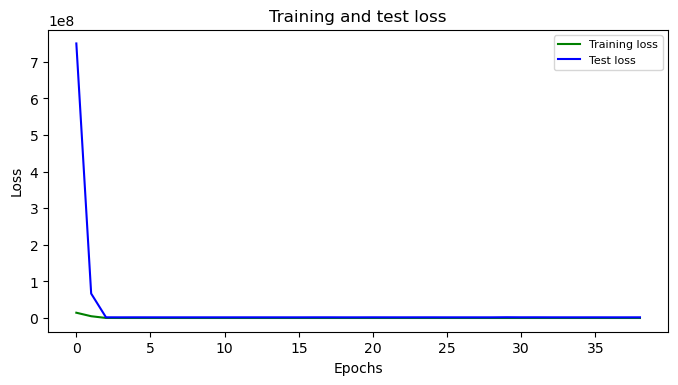

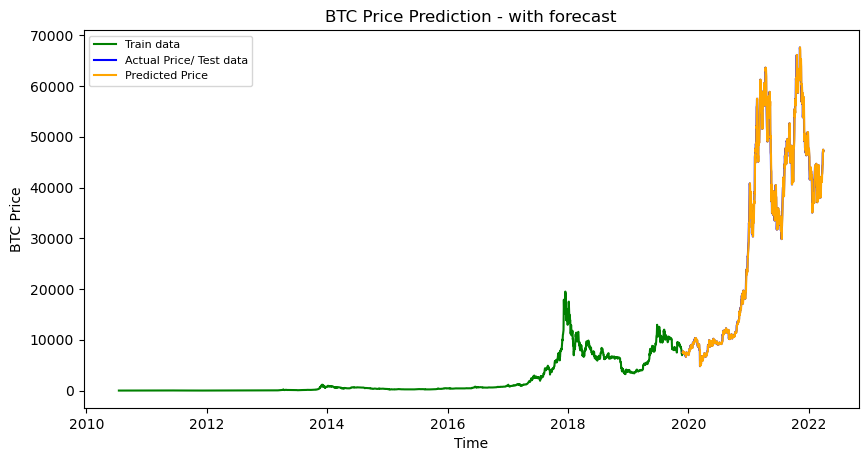

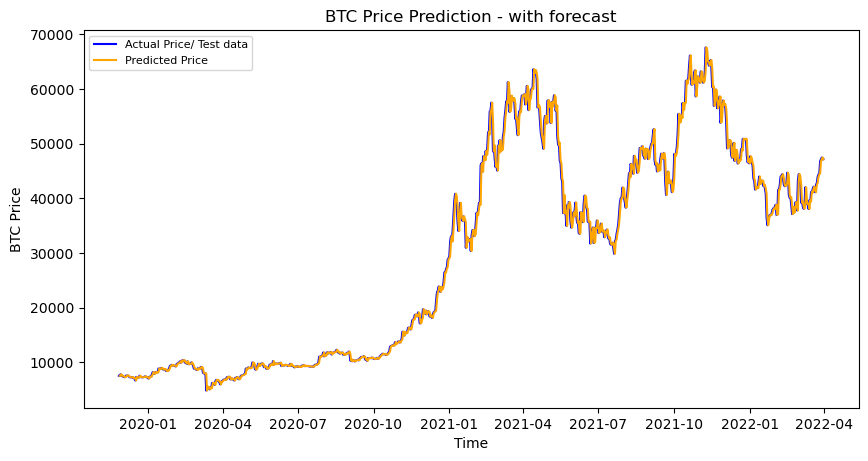

 33%|███▎      | 1/3 [00:54<01:49, 54.61s/it]

Sequential variant 1 : RMSE = 1351.900 


Data variant no: 2 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
20/20 [==============================] - 2s 22ms/step - loss: 377719872.0000 - val_loss: 2116540544.0000
Epoch 2/200
20/20 [==============================] - 0s 3ms/step - loss: 346911296.0000 - val_loss: 1920161024.0000
Epoch 3/200
20/20 [==============================] - 0s 3ms/step - loss: 312759680.0000 - val_loss: 1719822976.0000
Epoch 4/200
20/20 [===============

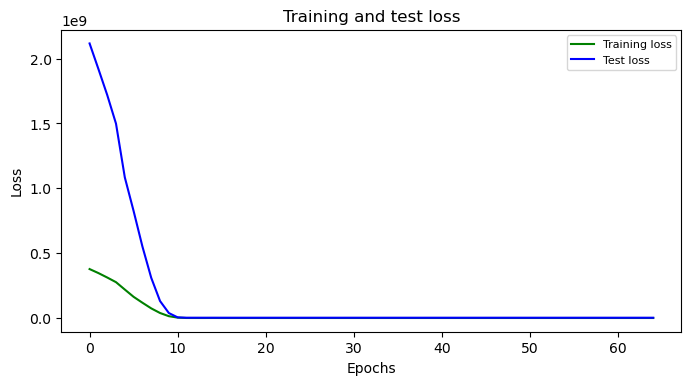

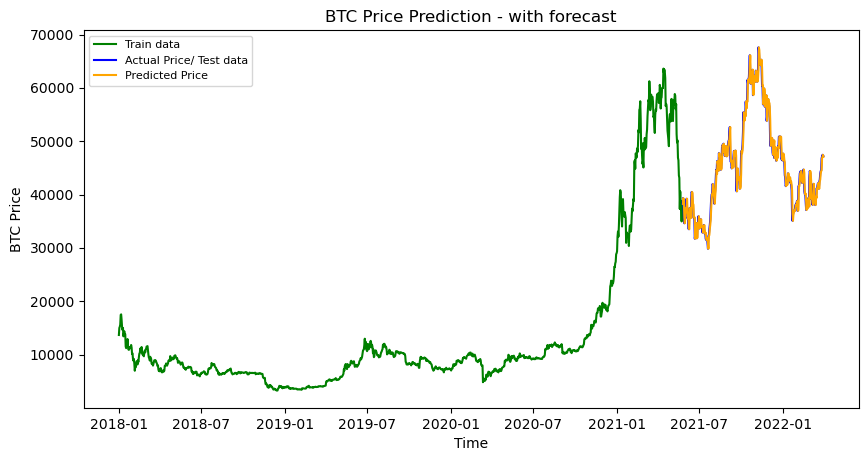

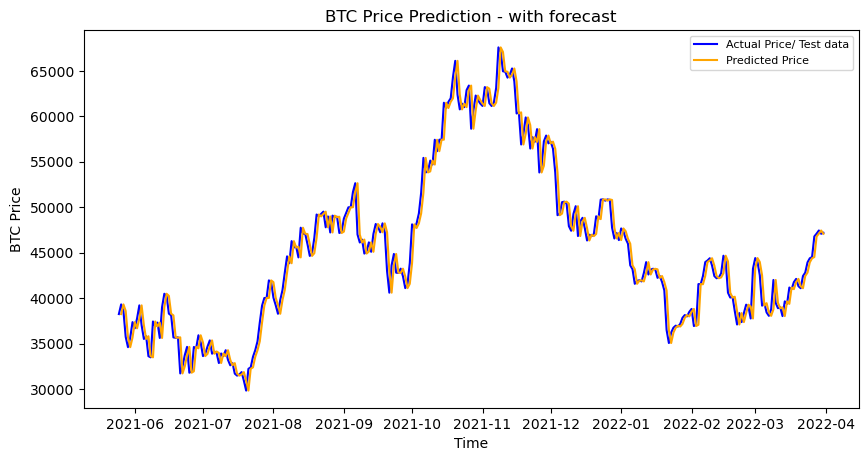

 67%|██████▋   | 2/3 [01:18<00:36, 36.39s/it]

Sequential variant 2 : RMSE = 1609.196 


Data variant no: 3 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
6/6 [==============================] - 2s 58ms/step - loss: 2406541056.0000 - val_loss: 1742250880.0000
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 2376730368.0000 - val_loss: 1720464128.0000
Epoch 3/200
6/6 [==============================] - 0s 9ms/step - loss: 2346829824.0000 - val_loss: 1698168064.0000
Epoch 4/200
6/6 [====================

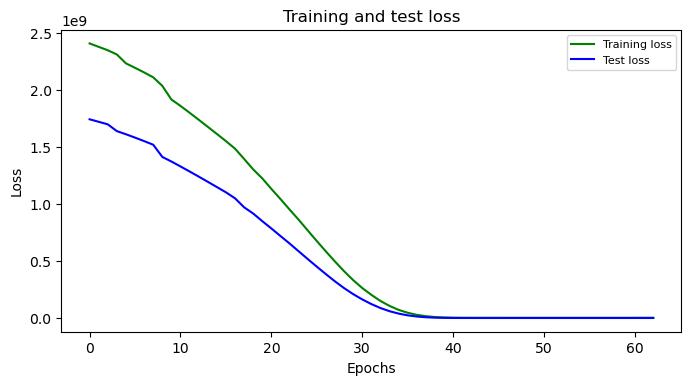

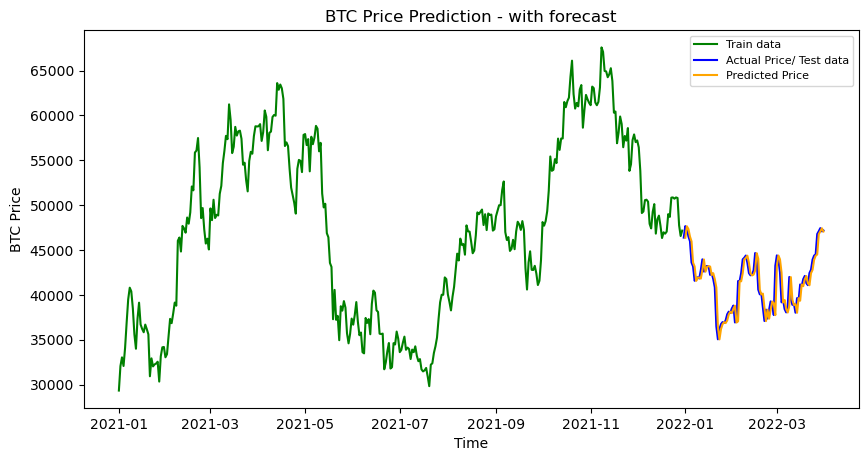

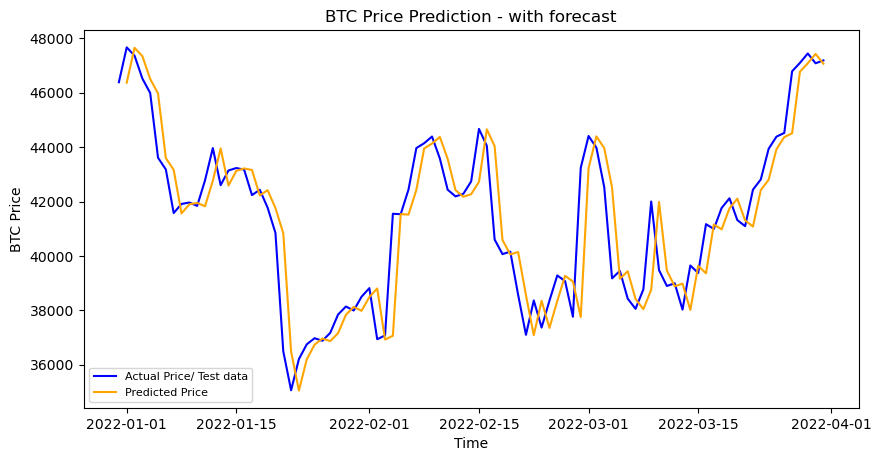

100%|██████████| 3/3 [01:28<00:00, 29.49s/it]

Sequential variant 3 : RMSE = 1409.957 

Wall time: 1min 28s


In [12]:
%%time

# Forecasting
lstm_variants_rmse = lstm_variants(df_variants=data_variants, train_size=0.8, steps=1)

### 7.4. LSTM  =>  summary

The bitcoin price forecast based on historical data was made using the LSTM model. The model parameters were selected empirically and applied equally to data variants. 

- In first try, complete dataset was used to tran the model.

- In second try, dataset was sliced, started from 2018-01-01.

- In third try, dataset was sliced, started from 2021-01-01.

In coparison of model performence of different data ranges, the best performence was for the complete data, then to past year + and at the end, to period of time around four years.

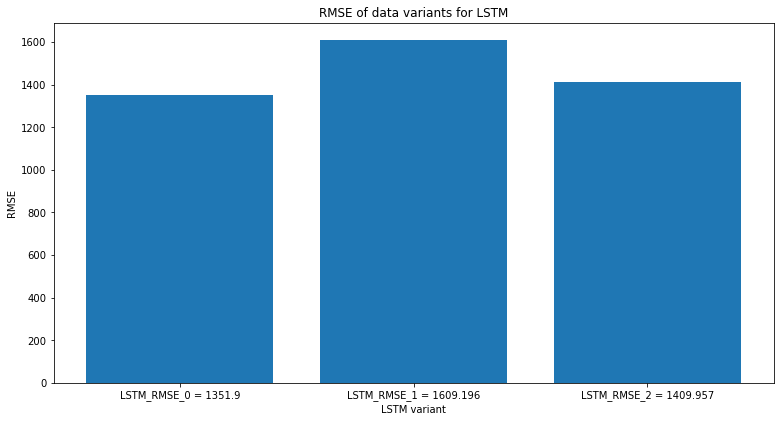

In [13]:
# plot for the RMSE's of data variants for LSTM

LSTM_variant = [("LSTM_RMSE_" + str(x)) for x in range(len(lstm_variants_rmse))]
summary = []

for variant, result in zip(LSTM_variant, lstm_variants_rmse):
    summary.append(variant + " = " + str(result))

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(summary, lstm_variants_rmse)

plt.xlabel("LSTM variant")
plt.ylabel("RMSE")
plt.title("RMSE of data variants for LSTM")
plt.show()

## 8. Project summary

This notebook was created to predict the Bitcoin price (in USD) using the LSTM model, along with notebooks for Bitcoin price prediction using ARIMA, XGBoost models. Each model used a the same three data ranges to generate forecasts.

The variant of the ARIMA model and LSTM model have similar approach for forecasting. Both look at close price of one past day for prediction of the close price of the next day. Performence of the models, measured by RMSE is also similar in every data range.

XGBRegressor variant have good results but a different approach in comparison of other models. For forecasting, columns "market_cap", "volume" has been used as well. The model is using GridSearchCV and "eval_set" on the fit () methodand L2 penalty specified by the author of the project.

In conclusion - the LSTM was the best model used to predict Bitcoin's price. This model gave relatively acceptable results with a short training time, regardless of the data period.